# User Features
In this notebook, we select the top 10k users `top_netflix_users.json` with the highest number of movie ratings and create user-specific features `user_profiles_{n}.pickle` as high/low ratios (on a scale of 0 to 1) for each movie feature base on their ratings.

Naturally, not all users have rated movies pertaining to the entire set of movie features. Such missing feature preference values are imputed as -1 for geometric interpretability in downstream tasks.

**Note**: The resulting `user_profiles_{n}.pickle` file is too large for Github. To produce the file, please run this notebook as is.

In [2]:
import os
import json
import pickle
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Constants
DATA_PATH = "../data"
OUTPUT_PATH = os.join(DATA_PATH, 'processed')
NETFLIX_FOLDER_PATH = os.path.join(DATA_PATH, "netflix_prize")
IMDB_FOLDER_PATH = os.path.join(DATA_PATH, "imdb")
MIN_OCCURRENCES = 20


## Get Top 10k Users

### Load Data

In [ ]:
# Load Netflix to IMDb mapping
with open(os.path.join(DATA_PATH, 'netflix_to_imdb.json'), 'r') as f:
    netflix_to_imdb = json.load(f)

# Convert Netflix movie IDs to a set of integers for faster lookup
netflix_movie_ids_with_imdb = set(int(k) for k in netflix_to_imdb.keys())

# Path to the training set
training_set_path = os.path.join(NETFLIX_FOLDER_PATH, 'training_set')
files = os.listdir(training_set_path)

### Count User Ratings For Each Movie

In [ ]:
# Initialize user ratings dictionary
user_ratings = defaultdict(lambda: {'total_ratings': 0, 'high_ratings': 0, 'low_ratings': 0})

# Process each file in the training set
for filename in files:
    filepath = os.path.join(training_set_path, filename)
    if filename.startswith('mv_') and filename.endswith('.txt'):
        movie_id = int(filename[3:-4])  # Extract movie ID as integer
        if movie_id in netflix_movie_ids_with_imdb:
            with open(filepath, 'r') as f:
                lines = f.readlines()
                for line in lines[1:]:  # Skip the first line containing the movie ID
                    user_id, rating, date = line.strip().split(',')
                    rating = int(rating)
                    user_ratings[user_id]['total_ratings'] += 1
                    if rating >= 4:
                        user_ratings[user_id]['high_ratings'] += 1
                    else:
                        user_ratings[user_id]['low_ratings'] += 1

Processing rating files...


TypeError: process_rating_file() missing 3 required positional arguments: 'movie_features', 'top_users', and 'user_profiles'

### Save Top 10k Users

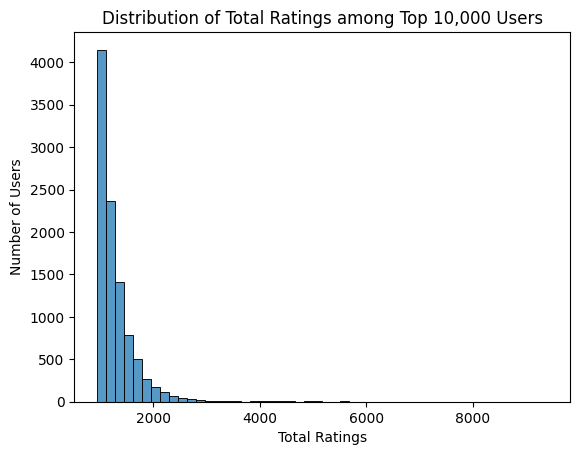

In [2]:
# Convert user ratings to a list and sort to find top 10,000 users
user_ratings_list = [(user_id, data) for user_id, data in user_ratings.items()]
user_ratings_list.sort(key=lambda x: x[1]['total_ratings'], reverse=True)
top_10000_users = user_ratings_list[:10000]

# Create a dictionary for the top 10,000 users
top_netflix_users = {user_id: data for user_id, data in top_10000_users}

# Save the top users to a JSON file
with open(os.path.join(OUTPUT_PATH, 'top_netflix_users.json'), 'w') as f:
    json.dump(top_netflix_users, f)

# Convert the top users dictionary to a DataFrame for visualization
df = pd.DataFrame.from_dict(top_netflix_users, orient='index')
df.reset_index(inplace=True)
df.rename(columns={'index': 'user_id'}, inplace=True)

# Visualization: Distribution of Total Ratings among Top 10,000 Users
sns.histplot(df['total_ratings'], bins=50)
plt.title('Distribution of Total Ratings among Top 10,000 Users')
plt.xlabel('Total Ratings')
plt.ylabel('Number of Users')
plt.show()


## Compute User Preference Features

### Load Data

In [3]:
# Load feature mapping
with open(os.path.join(DATA_PATH, f'processed/feature_mapping_{MIN_OCCURRENCES}.pickle'), 'rb') as f:
    feature_mapping = pickle.load(f)

# Load movie features
with open(os.path.join(DATA_PATH, f'processed/movie_features_{MIN_OCCURRENCES}.pickle'), 'rb') as f:
    movie_features = pickle.load(f)

# Load top Netflix users
with open(os.path.join(DATA_PATH, '/processed/top_netflix_users.json'), 'r') as f:
    top_netflix_users = json.load(f)

top_user_ids = set(top_netflix_users.keys())

# Get all feature IDs
all_feature_ids = set(feature_mapping['id_to_feature'].keys())

### Compute User Ratings Accross Features

In [4]:
# Initialize user profiles
user_profiles = {}

for user_id in top_user_ids:
    user_profiles[user_id] = {
        'feature_preferences': {},
        'feature_counts': {},
        'total_ratings': 0,
        'high_ratings': 0,
        'low_ratings': 0
    }

# Set of movie IDs that have features
movie_ids_with_features = set(movie_features.keys())

# Process ratings
training_set_path = os.path.join(NETFLIX_FOLDER_PATH, 'training_set')
files = os.listdir(training_set_path)

for filename in files:
    filepath = os.path.join(training_set_path, filename)
    if filename.startswith('mv_') and filename.endswith('.txt'):
        movie_id = filename[3:-4].lstrip('0')
        if not movie_id:
            movie_id = '0'
        # Check if movie_id is in movie_features
        if movie_id in movie_ids_with_features:
            # Get the features for the movie
            features = movie_features[movie_id]  # list of feature IDs
            with open(filepath, 'r') as f:
                lines = f.readlines()
                for line in lines[1:]:  # Skip the first line containing the movie ID
                    user_id, rating, date = line.strip().split(',')
                    if user_id in top_user_ids:
                        rating = int(rating)
                        user_profile = user_profiles[user_id]
                        user_profile['total_ratings'] += 1
                        if rating >= 4:
                            user_profile['high_ratings'] += 1
                            rating_type = 'high'
                        else:
                            user_profile['low_ratings'] += 1
                            rating_type = 'low'
                        # For each feature, update counts
                        for feature_id in features:
                            feature_id = int(feature_id)
                            if feature_id not in user_profile['feature_counts']:
                                user_profile['feature_counts'][feature_id] = {'total': 0, 'high': 0}
                            user_profile['feature_counts'][feature_id]['total'] += 1
                            if rating_type == 'high':
                                user_profile['feature_counts'][feature_id]['high'] += 1

### Compute Preference Distributions

In [5]:
# Calculate feature preference ratios
for user_id, user_profile in user_profiles.items():
    feature_preferences = {}
    feature_counts = user_profile['feature_counts']
    for feature_id in all_feature_ids:
        if feature_id in feature_counts:
            counts = feature_counts[feature_id]
            total = counts['total']
            high = counts['high']
            preference_ratio = high / total
        else:
            preference_ratio = -1
        feature_preferences[feature_id] = preference_ratio
    user_profile['feature_preferences'] = feature_preferences
    # Remove 'feature_counts' as it's no longer needed
    del user_profile['feature_counts']

# Save user profiles
with open(os.path.join(OUTPUT_PATH, f'user_profiles_{MIN_OCCURRENCES}.pickle'), 'wb') as f:
    pickle.dump(user_profiles, f)